# The QNLP Pipeline for Twitter Sentiment Analysis
## 1. Data Preprocess

In [1]:
import collections
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
from random import shuffle
import re
import spacy
from discopy.tensor import Tensor
from discopy import Word
from discopy.rigid import Functor
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import random, unique
from lambeq import AtomicType, IQPAnsatz, remove_cups, NumpyModel, spiders_reader
from lambeq import BobcatParser, TreeReader, cups_reader, DepCCGParser
from lambeq import Dataset
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import TketModel
from lambeq import SpacyTokeniser
from pytket.extensions.qiskit import AerBackend
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag, ne_chunk
from nltk.chunk import tree2conlltags

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('omw-1.4')

pd.set_option('display.width', 1000)
pd.options.display.max_colwidth=80
print(os.getcwd())
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
spacy.load('en_core_web_sm')

MAX_LENGTH = 5
BATCH_SIZE = 30
EPOCHS = 100
SEED = 0
random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/peiyongw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/peiyongw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/peiyongw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/peiyongw/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/peiyongw/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/peiyongw/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/peiyongw/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


/home/peiyongw/Desktop/Hackathon-QNLP


In [4]:
def get_sent_length(sent):
    if type(sent) is not str:
        return 9999999
    word_list = sent.split(" ")
    return len(word_list)

columns = ["Id","Entity","Target","Text"]
data = pd.read_csv(os.path.join(os.getcwd(),"data/twitter_training.csv"), names=columns,header=None)
#data = data.sample(frac=1).reset_index(drop=True)
data_val = pd.read_csv(os.path.join(os.getcwd(), "data/twitter_validation.csv"), names=columns,header=None)
#data_val = data.sample(frac=1).reset_index(drop=True)
df_train = data[["Text","Target"]]
df_train = df_train.loc[(df_train["Target"]=='Positive') | (df_train["Target"]=='Negative') & (df_train["Text"]!=np.nan)&(df_train["Text"].map(get_sent_length)<=MAX_LENGTH)]
df_train= df_train.drop_duplicates()
df_val = data_val[['Text', 'Target']]
df_val = df_val.loc[(df_val['Target'] == 'Positive') | (df_val['Target'] == 'Negative') & (df_val["Text"]!=np.nan)&(df_val["Text"].map(get_sent_length)<=MAX_LENGTH)]
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    
    without_emoji = emoji_pattern.sub(r'', text)
    
    tokens = word_tokenize(str(without_emoji).replace("'", "").lower()) 
    
    # Remove Puncs
    without_punc = [w for w in tokens if w.isalpha()]
    
    # Lemmatize
    text_len = [WordNetLemmatizer().lemmatize(t) for t in without_punc]
    # Stem
    text_cleaned = [PorterStemmer().stem(w) for w in text_len]
    
    return " ".join(text_cleaned)

df_train["Text"]= df_train["Text"].str.replace("im","i am")
df_train["Text"]= df_train["Text"].str.replace("it's","it is")
df_train["Text"]= df_train["Text"].str.replace("you're","you are")
df_train["Text"]= df_train["Text"].str.replace("hasn't","has not")
df_train["Text"]= df_train["Text"].str.replace("haven't","have not")
df_train["Text"]= df_train["Text"].str.replace("don't","do not")
df_train["Text"]= df_train["Text"].str.replace("doesn't","does not")
df_train["Text"]= df_train["Text"].str.replace("won't","will not")
df_train["Text"]= df_train["Text"].str.replace("shouldn't","should not")
df_train["Text"]= df_train["Text"].str.replace("can't","can not")
df_train["Text"]= df_train["Text"].str.replace("couldn't","could not")
df_val["Text"] = df_val["Text"].str.replace("im","i am")
df_val["Text"]= df_val["Text"].str.replace("it's","it is")
df_val["Text"]= df_val["Text"].str.replace("you're","you are")
df_val["Text"]= df_val["Text"].str.replace("hasn't","has not")
df_val["Text"]= df_val["Text"].str.replace("haven't","have not")
df_val["Text"] = df_val["Text"].str.replace("don't","do not")
df_val["Text"] = df_val["Text"].str.replace("doesn't","does not")
df_val["Text"] = df_val["Text"].str.replace("won't","will not")
df_val["Text"] = df_val["Text"].str.replace("shouldn't","should not")
df_val["Text"] = df_val["Text"].str.replace("can't","can not")
df_val["Text"] = df_val["Text"].str.replace("couldn't","could not")
df_train["Text"] = df_train["Text"].apply(preprocess)
df_val["Text"] = df_val["Text"].apply(preprocess)
df_train = df_train.dropna()
df_val = df_val.dropna()

negative_train_df = df_train.loc[df_train["Target"]=="Negative"]
positive_train_df = df_train.loc[df_train["Target"]=='Positive']

if len(positive_train_df)>=len(negative_train_df):
    positive_train_df = positive_train_df.head(len(negative_train_df))
else:
    negative_train_df = negative_train_df.head(len(positive_train_df))

negative_val_df = df_val.loc[df_val['Target'] == 'Negative']
positive_val_df = df_val.loc[df_val['Target'] == 'Positive']

if len(positive_val_df)>=len(negative_val_df):
    positive_val_df = positive_val_df.head(len(negative_val_df))
else:
    negative_val_df = negative_val_df.head(len(positive_val_df))

df_train = pd.concat([positive_train_df, negative_train_df])
df_val = pd.concat([positive_val_df, negative_val_df])

# Positive sentiment to [0,1], negative sentiment to [1,0]
sentiment_train = []
sentiment_val = []
for i in df_train["Target"]:
    if i == "Positive":
        sentiment_train.append([0,1])
    else:
        sentiment_train.append([1,0])

df_train["Sentiment"] = sentiment_train
        
for i in df_val["Target"]:
    if i == "Positive":
        sentiment_val.append([0,1])
    else:
        sentiment_val.append([1,0])

df_val["Sentiment"] = sentiment_val

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5214 entries, 0 to 74655
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5214 non-null   object
 1   Target     5214 non-null   object
 2   Sentiment  5214 non-null   object
dtypes: object(3)
memory usage: 162.9+ KB


In [6]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 6 to 983
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       56 non-null     object
 1   Target     56 non-null     object
 2   Sentiment  56 non-null     object
dtypes: object(3)
memory usage: 1.8+ KB


In [7]:
df_train.head()

,Text,Target,Sentiment
0,i am get on borderland and i will murder you all,Positive,"[0, 1]"
1,i am come to the border and i will kill you all,Positive,"[0, 1]"
2,i am get on borderland and i will kill you all,Positive,"[0, 1]"
3,i am come on borderland and i will murder you all,Positive,"[0, 1]"
4,i am get on borderland and i will murder you me all,Positive,"[0, 1]"


In [8]:
df_val.head()

,Text,Target,Sentiment
6,thank you eamaddennfl new te austin hooper in the orang brown brown pic twit...,Positive,"[0, 1]"
7,rocket leagu sea of thief or rainbow six sieg i love play all three on strea...,Positive,"[0, 1]"
8,my as still knee deep in assassin creed odyssey with no way out anyti ame so...,Positive,"[0, 1]"
10,the profession dota scene is fuck explod and i complet welcom it get the gar...,Positive,"[0, 1]"
11,itch to assassin tccgif assassinscreedblackflag assassinscre thecapturedcoll...,Positive,"[0, 1]"


<AxesSubplot:xlabel='Target', ylabel='count'>

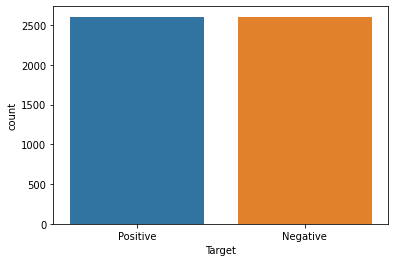

In [9]:
sns.countplot(x = "Target", data = df_train)

<AxesSubplot:xlabel='Target', ylabel='count'>

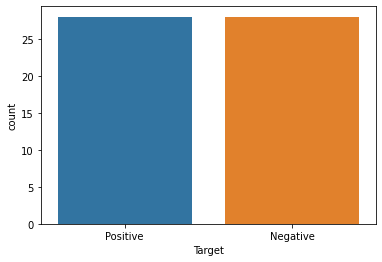

In [10]:
sns.countplot(x = "Target", data = df_val)

In [11]:
train_data_all, train_label_all = df_train["Text"].tolist(), df_train["Sentiment"].tolist()
dev_data, dev_labels = df_val["Text"].tolist(), df_val["Sentiment"].tolist()
data = train_data_all+dev_data
labels = train_label_all+dev_labels
pairs = []
for c in zip(labels, data):
    if len(c[1]) != 0 and len(c[1].split(" "))<=5:
        pairs.append(c)
random.seed(0)
random.shuffle(pairs)
N_EXAMPLES = len(pairs)
print("Total: {}".format(N_EXAMPLES))
TRAIN_RATIO_INDEX = 0.8
TEST_RATIO_INDEX = TRAIN_RATIO_INDEX + 0.1
DEV_RATIO_INDEX = TEST_RATIO_INDEX + 0.1
train_labels, train_data = zip(*pairs[:round(N_EXAMPLES * TRAIN_RATIO_INDEX)])
dev_labels, dev_data = zip(*pairs[round(N_EXAMPLES * TRAIN_RATIO_INDEX):round(N_EXAMPLES * TEST_RATIO_INDEX)])
test_labels, test_data = zip(*pairs[round(N_EXAMPLES * TEST_RATIO_INDEX):round(N_EXAMPLES * DEV_RATIO_INDEX)])
print("Data selected for train: {}\nData selected for test: {}\nData selected for dev: {}".format(len(train_data), len(test_data), len(dev_data)))

Total: 2893
Data selected for train: 2314
Data selected for test: 289
Data selected for dev: 290


In [12]:
# Function for replacing low occuring word(s) with <unk> token
def replace(box):
    if isinstance(box, Word) and dataset.count(box.name) < 1:
        return Word('unk', box.cod, box.dom)
    return box

In [13]:
tokeniser = SpacyTokeniser()

In [14]:
train_data = tokeniser.tokenise_sentences(train_data)
dev_data = tokeniser.tokenise_sentences(dev_data)
test_data = tokeniser.tokenise_sentences(test_data)

In [15]:
for i in range(len(train_data)):
    train_data[i] = ' '.join(train_data[i])

for i in range(len(dev_data)):
    dev_data[i] = ' '.join(dev_data[i])

for i in range(len(test_data)):
    test_data[i] = ' '.join(test_data[i])

In [16]:
# training set words (with repetition)
train_data_string = ' '.join(train_data)
train_data_list = train_data_string.split(' ')
# validation set words (with repetition)
dev_data_string = ' '.join(dev_data)
dev_data_list = dev_data_string.split(' ')
# test set words (with repetition)
test_data_string = ' '.join(test_data)
test_data_list = test_data_string.split(' ')

In [17]:
# dataset words (with repetition)
dataset = train_data_list + dev_data_list + test_data_list
# list of all unique words in the dataset
unique_words = unique(dataset)
# frequency for each unique word
counter = collections.Counter(dataset)
#print(counter)

In [18]:
replace_functor = Functor(ob=lambda x: x, ar=replace)

In [19]:
# parser = BobcatParser(verbose='text')
print(BobcatParser.available_models())
parser = spiders_reader
#parser = DepCCGParser()
#parser = cups_reader

['bert']


In [20]:
raw_train_diagrams = []
new_train_labels = []
raw_dev_diagrams = []
new_dev_labels = []
raw_test_diagrams = []
new_test_labels = []
for sent, label in zip(train_data, train_labels):
    try:
        diag = parser.sentence2diagram(sent)
        raw_train_diagrams.append(diag)
        new_train_labels.append(label)
    except:
        print("Cannot be parsed in train: {}".format(sent))

for sent, label in zip(dev_data, dev_labels):
    try:
        diag = parser.sentence2diagram(sent)
        raw_dev_diagrams.append(diag)
        new_dev_labels.append(label)
    except:
        print("Cannot be parsed in dev: {}".format(sent))        


for sent, label in zip(test_data, test_labels):
    try:
        diag = parser.sentence2diagram(sent)
        raw_test_diagrams.append(diag)
        new_test_labels.append(label)
    except:
        print("Cannot be parsed in test: {}".format(sent))

train_labels = new_train_labels
dev_labels = new_dev_labels
test_labels = new_test_labels

## 2. Construct the circuits

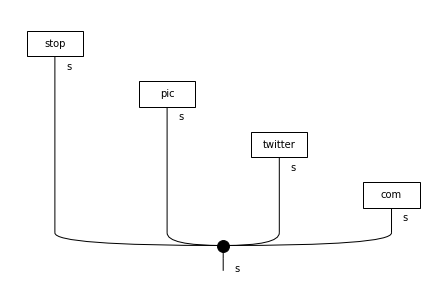

In [21]:
# # Tokenizing low occuring words in each dataset
for i in range(len(raw_train_diagrams)):
    raw_train_diagrams[i] = replace_functor(raw_train_diagrams[i])

for i in range(len(raw_dev_diagrams)):
    raw_dev_diagrams[i] = replace_functor(raw_dev_diagrams[i])

for i in range(len(raw_test_diagrams)):
    raw_test_diagrams[i] = replace_functor(raw_test_diagrams[i])

# sample sentence diagram (entry 1)
raw_train_diagrams[0].draw()

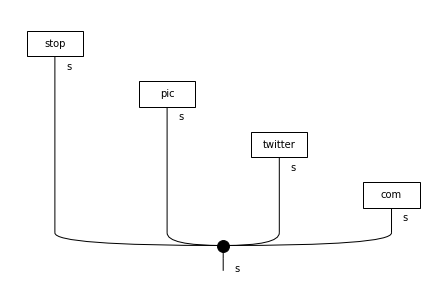

In [22]:
# merging all diagrams into one for checking the new words
raw_all_diagrams = raw_train_diagrams + raw_dev_diagrams + raw_test_diagrams

# removing cups (after performing top-to-bottom scan of the word diagrams)
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

# sample sentence diagram (entry 1)
train_diagrams[0].draw()

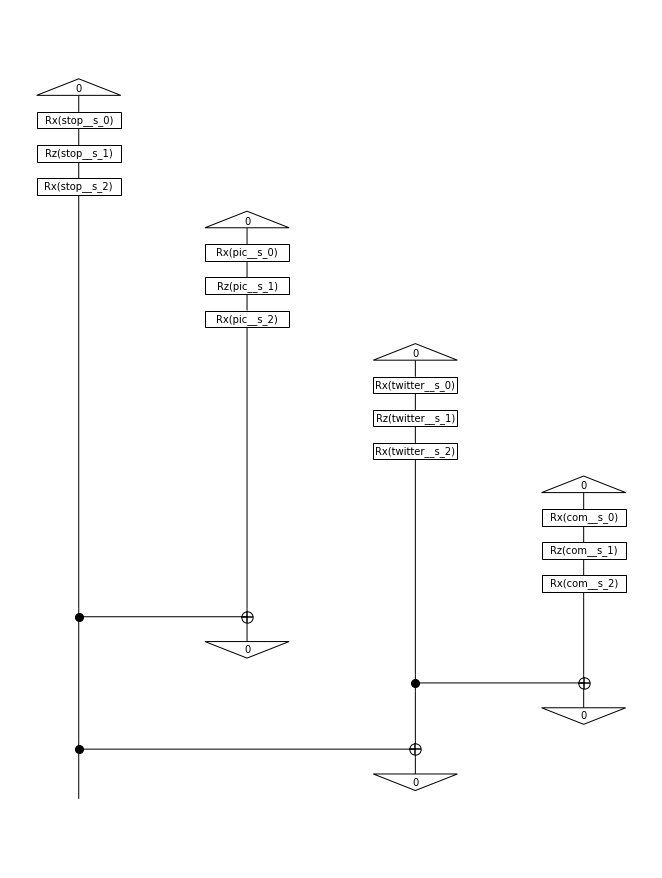

In [23]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.NOUN_PHRASE:1, AtomicType.CONJUNCTION:1}, n_layers=1, n_single_qubit_params=3)

# train/test circuits
train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits = [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

# sample circuit diagram
train_circuits[0].draw(figsize=(9, 12))

## 3. Training

In [24]:
all_circuits = train_circuits + dev_circuits + test_circuits
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [25]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

In [26]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

In [27]:
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [28]:
trainer.fit(train_dataset, val_dataset, logging_step=12)

KeyboardInterrupt: 

In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)